# 机器学习实验报告-lab4-朴素贝叶斯
**姓名：** 郭裕彬
**学号：** 2114052
**专业：** 物联网工程
## 实验要求
### 基本要求
1. 采用分层采样的方式将数据集划分为训练集和测试集。
2. 给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。
### 中级要求
使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。
### 高级要求
在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。
### 扩展要求
浅谈ROC曲线和AUC值作为分类评价的合理性。

In [44]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [45]:
label = [[], [], []]#记录不同标签下的数据
train_data = [[], [], []]#分层后的训练数据
test_data = [[], [], []]#分层后的抽样数据
num_iterations = 10#折数
error_count = 0
means = [[], [], []]#不同类的均值
variances = [[], [], []]#不同类的方差
confusion_matrix = np.zeros([3, 3])#混淆矩阵
record = []#记录测试时的数据
data_number = 0#数据总量

#从文件中获取数据并分类
data = list(np.loadtxt('wine.data', delimiter=','))
data = np.array(data)
for i in data:
    if i[0] == 1:
        label[0].append(i[1:14])
    elif i[0] == 2:
        label[1].append(i[1:14])
    else:
        label[2].append(i[1:14])
    data_number += 1
data_length = [round(len(label[i]) / num_iterations) for i in range(3)]#交叉验证时的取样比例

## 基本要求

In [46]:
#朴素贝叶斯实现
def naive_bayes():
    error_num = 0
    for i in range(3):
        means[i] = np.mean(train_data[i], axis=0)#计算每个类的均值
        variances[i] = np.var(train_data[i], axis=0)#计算每个类的方差
    for i in range(3):#依次对不同类的测试数据进行概率计算
        for j in test_data[i]:
            posterior = []
            for k in range(3):
                likelihood = np.power((j - means[k]), 2) / (2 * variances[k])
                probability = np.log(np.sqrt(2 * np.pi * variances[k])) + likelihood
                probability = np.sum(probability)
                posterior.append(-probability + math.log(len(label[k]) / data_number))
            #分类错误时error_num+1
            if np.argmax(posterior) != i:
                error_num += 1
            #记录混淆矩阵中的数据
            confusion_matrix[i][np.argmax(posterior)] += 1
            posterior.append(i)
            #记录测试数据
            record.append(posterior)
    return error_num

In [47]:
#分层抽样进行测试
for i in range(num_iterations):
    train_data = [np.mat(label[j][:i * data_length[j]] + label[j][(i + 1) * data_length[j]:])
                  if (i + 1) * data_length[j] <= len(label[j])
                  else np.mat(label[j][:i * data_length[j]])
                  for j in range(3)]

    test_data = [np.mat(label[j][i * data_length[j]:(i + 1) * data_length[j]])
                 if (i + 1) * data_length[j] <= len(label[j])
                 else np.mat(label[j][i * data_length[j]:])
                 for j in range(3)]
    error_count += naive_bayes()
print(f"分类准确率为：{1 - error_count / data_number}")

分类准确率为：0.9775280898876404


## 中级要求

In [48]:
precision = []
recall = []
F_measure = []
#根据多分类混淆矩阵相关理论计算各类的精确率、召回率和F值
for i in range(3):
    precision.append(round(confusion_matrix[i][i] / (confusion_matrix[0][i] + confusion_matrix[1][i] + confusion_matrix[2][i]),4))
    recall.append(round(confusion_matrix[i][i] / (confusion_matrix[i][0] + confusion_matrix[i][1] + confusion_matrix[i][2]),4))
    F_measure.append(round(2 * precision[i] * recall[i] / (precision[i] + recall[i]),4))

print("1、2、3类酒的精确率是",precision)
print("1、2、3类酒的召回率是",recall)
print("1、2、3类酒的F值是",F_measure)

1、2、3类酒的精确率是 [1.0, 0.9714, 0.96]
1、2、3类酒的召回率是 [0.9661, 0.9714, 1.0]
1、2、3类酒的F值是 [0.9828, 0.9714, 0.9796]


## 高级要求

In [49]:
#画出ROC曲线，计算AUC
def cal_roc():
    for i in range(3):
        fp_rate = []
        tp_rate = []
        auc = 0.0
        sort_data = sorted(record, key = lambda x:x[i])#按照第i类概率排序
        pos_record = [j for j in sort_data if j[3] == i]#正样本
        neg_record = [j for j in sort_data if j[3] != i]#负样本
        pos_number = len(pos_record)
        neg_number = len(neg_record)
        for j in sort_data:
            fp_count = 0
            tp_count = 0
            middle = j[i]
            #以j的值作为阈值判断正负
            for k in pos_record:
                if k[i] >= middle:
                    tp_count += 1
            for k in neg_record:
                if k[i]>= middle:
                    fp_count += 1
            fp_rate.append(fp_count / neg_number)
            tp_rate.append(tp_count / pos_number)
        fp_rate.append(0)
        tp_rate.append(0)
        #计算AUC
        for j in pos_record:
            for k in neg_record:
                if j[i]>k[i]:
                    auc += 1
                elif j[i] == k[i]:
                    auc += 0.5
        auc /= (pos_number * neg_number)
        AUC.append(auc)
        fpr.append(fp_rate)
        tpr.append(tp_rate)
        print("1、2、3类酒的AUC是",round(auc,4))

1、2、3类酒的AUC是 0.9948
1、2、3类酒的AUC是 0.9338
1、2、3类酒的AUC是 0.9926


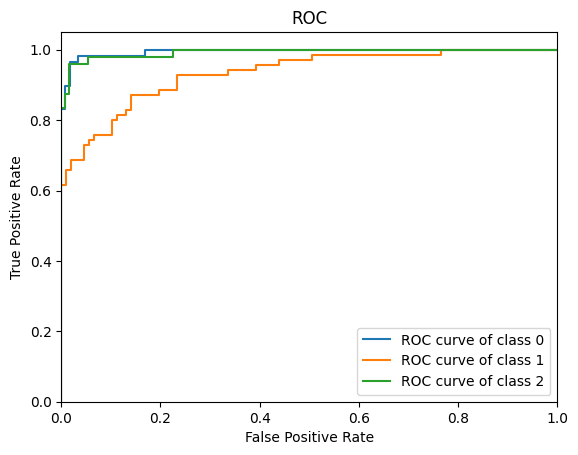

In [50]:
fpr = []
tpr = []
AUC = []
cal_roc()

for i in range(3):
    plt.plot(fpr[i], tpr[i],label='ROC curve of class {0}'.format (i))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## 扩展要求
ROC曲线能够展示在不同阈值下模型的真正例率和假正例率，从而全面反映了分类器的性能。这种全面性评估对于不同应用场景中的权衡取舍至关重要。ROC曲线和AUC值的计算基于真正例率和假正例率，不受类别不平衡的干扰，因此对于不同样本分布的问题更具鲁棒性。当测试集中的正负样本的分布变化的时候，ROC曲线能够保持不变。在实际的数据集中经常会出现类不平衡（class imbalance）现象，即负样本比正样本多很多（或者相反），而且测试数据中的正负样本的分布也可能随着时间变化，因此ROC曲线比二级指标精确率-召回率曲线更准确。
很多时候ROC曲线并不能清晰的说明哪个分类器的效果更好，而使用AUC值这样一个数值作为评价标准，对应AUC更大的分类器效果更好。但一些研究指出，AUC的杂讯太多，并且很常求不出可信又有效的AUC值，使得AUC在模型比较时产生的问题比解释的问题更多，因此使用AUC作为ROC曲线的数据化表示需要根据实际情况进行分析。